In [12]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import cv2
import numpy as np
from loadimages import load_images
import random
from models import FlowNetVector
from matplotlib import pyplot as plt

In [2]:
sequences = load_images(1)
random.shuffle(sequences)
sequences = sequences[:100]

mse_loss = nn.MSELoss()
avg_pool = nn.AvgPool2d(2)
upsample_16 = nn.Upsample(scale_factor=16, mode='nearest')
upsample_32 = nn.Upsample(scale_factor=32, mode='nearest')
upsample_64 = nn.Upsample(scale_factor=64, mode='nearest')
upsample_128 = nn.Upsample(scale_factor=128, mode='nearest')

In [3]:
def get_block_vector(block1, block2, block_size):
  x_y = [0, 0]
  min_error = float('inf')
  for i in range(2 * block_size):
    for j in range(2 * block_size):
      error = mse_loss(block1, block2[:,i:i + block_size, j:j + block_size])
      if error < min_error:
        min_error = error
        x_y = [block_size - i - 1, block_size - j - 1]
  return x_y

In [4]:
def get_vector_layer(image1, image2, size):
  vectors = np.zeros(size)
  for j in range(1, size[0] + 1):
    for k in range(1, size[1] + 1):
      x_y = get_block_vector(
        image1[:,j * block_size: j * block_size + block_size,k * block_size: k * block_size + block_size],
        image2[:,(j - 1) * block_size: (j + 2) * block_size,(k - 1) * block_size: (k + 2) * block_size],
        block_size
      )
      vectors[j - 1][k - 1][0] = x_y[0]
      vectors[j - 1][k - 1][1] = x_y[1]
  return vectors

In [5]:
def downsize_images(image1, image2):
  image1 = avg_pool(image1)
  image2 = avg_pool(image2)
  return (image1, image2)

In [6]:
block_size = 16
def find_motion_vectors(image1, image2):
  first_layer_vectors = torch.tensor(get_vector_layer(image1, image2, (30, 22, 2)).flatten())

  (image1, image2) = downsize_images(image1, image2)
  second_layer_vectors = torch.tensor(get_vector_layer(image1, image2, (14, 10, 2)).flatten())

  (image1, image2) = downsize_images(image1, image2)
  third_layer_vectors = torch.tensor(get_vector_layer(image1, image2, (6, 4, 2)).flatten())

  (image1, image2) = downsize_images(image1, image2)
  fourth_layer_vectors = torch.tensor(get_vector_layer(image1, image2, (2, 1, 2)).flatten())
  
  return torch.cat((first_layer_vectors, second_layer_vectors, third_layer_vectors, fourth_layer_vectors), axis=0)  

In [7]:
def find_motion_images(image1, image2):
  first_layer_vector_image = get_vector_layer(image1, image2, (30, 22, 2))

  (image1, image2) = downsize_images(image1, image2)
  second_layer_vector_image = get_vector_layer(image1, image2, (14, 10, 2))

  (image1, image2) = downsize_images(image1, image2)
  third_layer_vector_image = get_vector_layer(image1, image2, (6, 4, 2))

  (image1, image2) = downsize_images(image1, image2)
  fourth_layer_vector_image = get_vector_layer(image1, image2, (2, 1, 2))
  
  img_f1_x = upsample_16(torch.tensor(np.pad(first_layer_vector_image[:,:,0], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f1_y = upsample_16(torch.tensor(np.pad(first_layer_vector_image[:,:,1], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f2_x = upsample_32(torch.tensor(np.pad(second_layer_vector_image[:,:,0], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f2_y = upsample_32(torch.tensor(np.pad(second_layer_vector_image[:,:,1], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f3_x = upsample_64(torch.tensor(np.pad(third_layer_vector_image[:,:,1], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f3_y = upsample_64(torch.tensor(np.pad(third_layer_vector_image[:,:,1], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f4_x = upsample_128(torch.tensor(np.pad(fourth_layer_vector_image[:,:,0], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)
  img_f4_y = upsample_128(torch.tensor(np.pad(fourth_layer_vector_image[:,:,1], ((1, 1), (1, 1)), mode='constant')).unsqueeze(0).unsqueeze(0).type(torch.cuda.FloatTensor)).squeeze(0)

  return  (img_f1_x, img_f1_y, img_f2_x, img_f2_y, img_f3_x, img_f3_y, img_f4_x, img_f4_y)

In [8]:
vectors = list()
for sequence in sequences:
  (img_f1_x, img_f1_y, img_f2_x, img_f2_y, img_f3_x, img_f3_y, img_f4_x, img_f4_y) = find_motion_images(sequence[0][:3], sequence[0][3:6])
  print(img_f1_x.shape)
  vectors.append([
    torch.cat((
      sequence[0], img_f1_x, img_f1_y, img_f2_x, img_f2_y, img_f3_x, img_f3_y, img_f4_x, img_f4_y
    ), 0).type(torch.cuda.FloatTensor),
    sequence[1]])

torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([1, 512, 384])
torch.Size([

In [9]:
number_of_epochs = 100
model = FlowNetVector()
loss_fn = nn.MSELoss()
# model.load_state_dict(torch.load('./etc.pt))
model.cuda()
learning_rate = 1e-1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)

In [10]:
training_losses = []
validation_losses = []
training_range = int(len(sequences) * 0.8)

print('started training')
for epoch in range(number_of_epochs):
  training_loss = 0.0
  validation_loss = 0.0
  for data in vectors[:training_range]:
    out = model(data[0].unsqueeze(0))
    loss = loss_fn(out.squeeze(0), data[1])
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 6.0)
    training_loss += loss.item()
    optimizer.step()

  for data in vectors[training_range:]:
    out = model(data[0].unsqueeze(0))
    loss = loss_fn(out.squeeze(0), data[1])
    validation_loss += loss.item()
    
  training_losses.append(training_loss)
  validation_losses.append(validation_loss)
  torch.save(model.state_dict(), './vectornet.pt')
  print('Training loss: ' + str(training_loss) + ' ; Validation loss: ' + str(validation_loss) + ' ; Epoch: ' + str(epoch))

started training
Training loss: 960048.0955810547 ; Validation loss: 203628.91064453125 ; Epoch: 0
Training loss: 668608.5571899414 ; Validation loss: 142189.59985351562 ; Epoch: 1
Training loss: 466206.0215148926 ; Validation loss: 99572.12841796875 ; Epoch: 2
Training loss: 326004.5310821533 ; Validation loss: 69671.068359375 ; Epoch: 3
Training loss: 230615.0905456543 ; Validation loss: 49948.13049316406 ; Epoch: 4
Training loss: 169348.34936523438 ; Validation loss: 37255.65948486328 ; Epoch: 5
Training loss: 130293.3002243042 ; Validation loss: 29041.398040771484 ; Epoch: 6
Training loss: 105339.35437774658 ; Validation loss: 23873.924896240234 ; Epoch: 7
Training loss: 88996.55165863037 ; Validation loss: 20393.75415802002 ; Epoch: 8
Training loss: 78278.27422332764 ; Validation loss: 18165.67071533203 ; Epoch: 9
Training loss: 71146.7497177124 ; Validation loss: 16392.789947509766 ; Epoch: 10
Training loss: 66165.08713531494 ; Validation loss: 15276.70491027832 ; Epoch: 11
Train

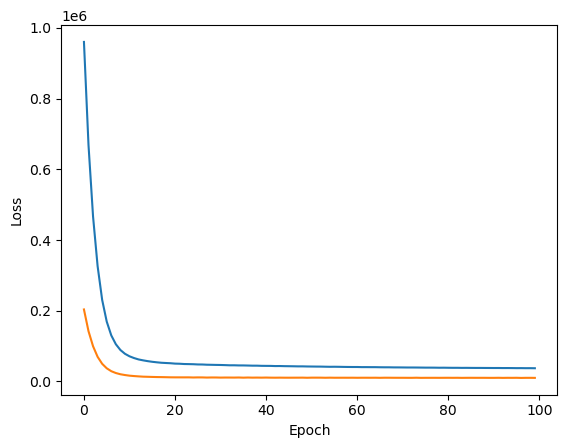

In [13]:
plt.plot(training_losses)
plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()